In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

In [2]:
# NEP
# f'test60_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test78_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test87_linreg_nc{n_clusters}_nv8_nd9_noTS'
# NWP
# f'test4_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test25_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test83_linreg_nc{n_clusters}_nv8_nd9_noTS'
# NA
# f'test3_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test14_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test61_linreg_nc{n_clusters}_nv8_nd9_noTS'
# NI
# f'test26_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test32_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test45_linreg_nc{n_clusters}_nv8_nd9_noTS'
# SI
# f'test12_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test51_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test82_linreg_nc{n_clusters}_nv8_nd9_noTS'
# SP
# f'test8_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test23_linreg_nc{n_clusters}_nv8_nd9_noTS'
# f'test98_linreg_nc{n_clusters}_nv8_nd9_noTS'

In [3]:
basin = 'NA'
n_clusters_dict = {'NEP': 9, 'NWP': 8, 'NA': 12, 'NI': 9, 'SI': 10, 'SP': 11}
n_clusters = n_clusters_dict[basin]
# run_name = f'selfeat80_top20_nc{n_clusters}_nv8_nd9_noTS'
run_name = f'test14_linreg_nc{n_clusters}_nv8_nd9_noTS'

In [6]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
cluster_data = f'{basin}_{n_clusters}clusters_noTS'
cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
# predictors
predictor_file = f'predictors_1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
predictors_df = pd.read_csv(os.path.join(cluster_data_dir, predictor_file), index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
predictors_df = predictors_df.loc[predictors_df.index.year.isin(years)]
# target
target_file = 'target_residual_1980-2022_2.5x2.5.csv'
seasonal_file = 'target_seasonality_1980-2022_2.5x2.5.csv'
trend_file = 'target_trend_1980-2022_2.5x2.5.csv'
target_df = pd.read_csv(os.path.join(cluster_data_dir, target_file), index_col=0)
target_df.index = pd.to_datetime(target_df.index)
target_df = target_df.loc[target_df.index.year.isin(years)]
target_season_df = pd.read_csv(os.path.join(cluster_data_dir, seasonal_file), index_col=0)
target_season_df.index = pd.to_datetime(target_season_df.index)
target_season_df = target_season_df.loc[target_season_df.index.year.isin(years)]
target_trend_df = pd.read_csv(os.path.join(cluster_data_dir, trend_file), index_col=0)
target_trend_df.index = pd.to_datetime(target_trend_df.index)
target_trend_df = target_trend_df.loc[target_trend_df.index.year.isin(years)]
# gpis
gpis_file = f'{basin}_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# Get the run info and data
Y_pred, Y_pred_noFS, X_test_eval, X_test_eval_noFS, mlps, mlps_noFS, perm_importance_mlp, perm_importance_mlp_noFS, shap_values_mlp, shap_values_mlp_noFS = ut.runs_info(basin, run_name)
# Convert list of dataframes to a single dataframe
X_test = pd.concat(X_test_eval)
X_test_noFS = pd.concat(X_test_eval_noFS)
Y_pred_df = pd.concat(Y_pred)
Y_pred_noFS_df = pd.concat(Y_pred_noFS)

2025-03-21 19:42:10.505190: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-03-21 19:42:10.505223: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-03-21 19:42:10.505227: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-03-21 19:42:10.505258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-21 19:42:10.505273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-21 19:42:10.808806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


**Time series Trajectories and Metrics**

In [7]:
# Target with trend and seasonality
target_df_TS = target_df['resid'] + target_trend_df['trend'] + target_season_df['season']
# Predictions with trend and seasonality
Y_pred_df_TS = Y_pred_df['resid'] + target_trend_df['trend'] + target_season_df['season']
Y_pred_noFS_df_TS = Y_pred_noFS_df['resid'] + target_trend_df['trend'] + target_season_df['season']
Y_pred_df_TS[Y_pred_df_TS < 0] = 0.0
Y_pred_noFS_df_TS[Y_pred_noFS_df_TS < 0] = 0.0
# Annual data without trend and seasonality
target_df_annual = target_df.groupby(target_df.index.year).sum()
Y_pred_df_annual = Y_pred_df.groupby(Y_pred_df.index.year).sum()
Y_pred_noFS_df_annual = Y_pred_noFS_df.groupby(Y_pred_noFS_df.index.year).sum()
# Annual data with trend and seasonality
target_df_annual_TS = target_df_TS.groupby(target_df_TS.index.year).sum()
Y_pred_df_annual_TS = Y_pred_df_TS.groupby(Y_pred_df_TS.index.year).sum()
Y_pred_noFS_df_annual_TS = Y_pred_noFS_df_TS.groupby(Y_pred_noFS_df_TS.index.year).sum()
# GPIs time series with trend and seasonality
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
# GPIs time series without trend and seasonality
decomp_engpi = STL(engpi_TS).fit()
trend_engpi = decomp_engpi.trend
seasonal_engpi = decomp_engpi.seasonal
engpi = decomp_engpi.resid
decomp_ogpi = STL(ogpi_TS).fit()
trend_ogpi = decomp_ogpi.trend
seasonal_ogpi = decomp_ogpi.seasonal
ogpi = decomp_ogpi.resid
# Annual data of the GPIs
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
engpi_annual_TS = engpi_TS.groupby(engpi_TS.index.year).sum()
ogpi_annual_TS = ogpi_TS.groupby(ogpi_TS.index.year).sum()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly without trend and seasonality
r, _ = pearsonr(target_df['resid'], Y_pred_df['resid'])
r_noFS, _ = pearsonr(target_df['resid'], Y_pred_noFS_df['resid'])
r_engpi, _ = pearsonr(target_df['resid'], engpi)
r_ogpi, _ = pearsonr(target_df['resid'], ogpi)
mse = mean_squared_error(target_df['resid'], Y_pred_df['resid'])
mse_noFS = mean_squared_error(target_df['resid'], Y_pred_df['resid'])
mse_engpi = mean_squared_error(target_df['resid'], engpi)
mse_ogpi = mean_squared_error(target_df['resid'], ogpi)
# Monthly with trend and seasonality
r_TS, _ = pearsonr(target_df_TS, Y_pred_df_TS)
r_noFS_TS, _ = pearsonr(target_df_TS, Y_pred_noFS_df_TS)
r_engpi_TS, _ = pearsonr(target_df_TS, engpi_TS)
r_ogpi_TS, _ = pearsonr(target_df_TS, ogpi_TS)
mse_TS = mean_squared_error(target_df_TS, Y_pred_df_TS)
mse_noFS_TS = mean_squared_error(target_df_TS, Y_pred_noFS_df_TS)
mse_engpi_TS = mean_squared_error(target_df_TS, engpi_TS)
mse_ogpi_TS = mean_squared_error(target_df_TS, ogpi_TS)
# Annual without trend and seasonality
rY, _ = pearsonr(target_df_annual['resid'], Y_pred_df_annual['resid'])
rY_noFS, _ = pearsonr(target_df_annual['resid'], Y_pred_noFS_df_annual['resid'])
rY_engpi, _ = pearsonr(target_df_annual['resid'], engpi_annual)
rY_ogpi, _ = pearsonr(target_df_annual['resid'], ogpi_annual)
mseY = mean_squared_error(target_df_annual['resid'], Y_pred_df_annual['resid'])
mseY_noFS = mean_squared_error(target_df_annual['resid'], Y_pred_noFS_df_annual['resid'])
mseY_engpi = mean_squared_error(target_df_annual['resid'], engpi_annual)
mseY_ogpi = mean_squared_error(target_df_annual['resid'], ogpi_annual)
# Annual with trend and seasonality
rY_TS, _ = pearsonr(target_df_annual_TS, Y_pred_df_annual_TS)
rY_noFS_TS, _ = pearsonr(target_df_annual_TS, Y_pred_noFS_df_annual_TS)
rY_engpi_TS, _ = pearsonr(target_df_annual_TS, engpi_annual_TS)
rY_ogpi_TS, _ = pearsonr(target_df_annual_TS, ogpi_annual_TS)
mseY_TS = mean_squared_error(target_df_annual_TS, Y_pred_df_annual_TS)
mseY_noFS_TS = mean_squared_error(target_df_annual_TS, Y_pred_noFS_df_annual_TS)
mseY_engpi_TS = mean_squared_error(target_df_annual_TS, engpi_annual_TS)
mseY_ogpi_TS = mean_squared_error(target_df_annual_TS, ogpi_annual_TS)

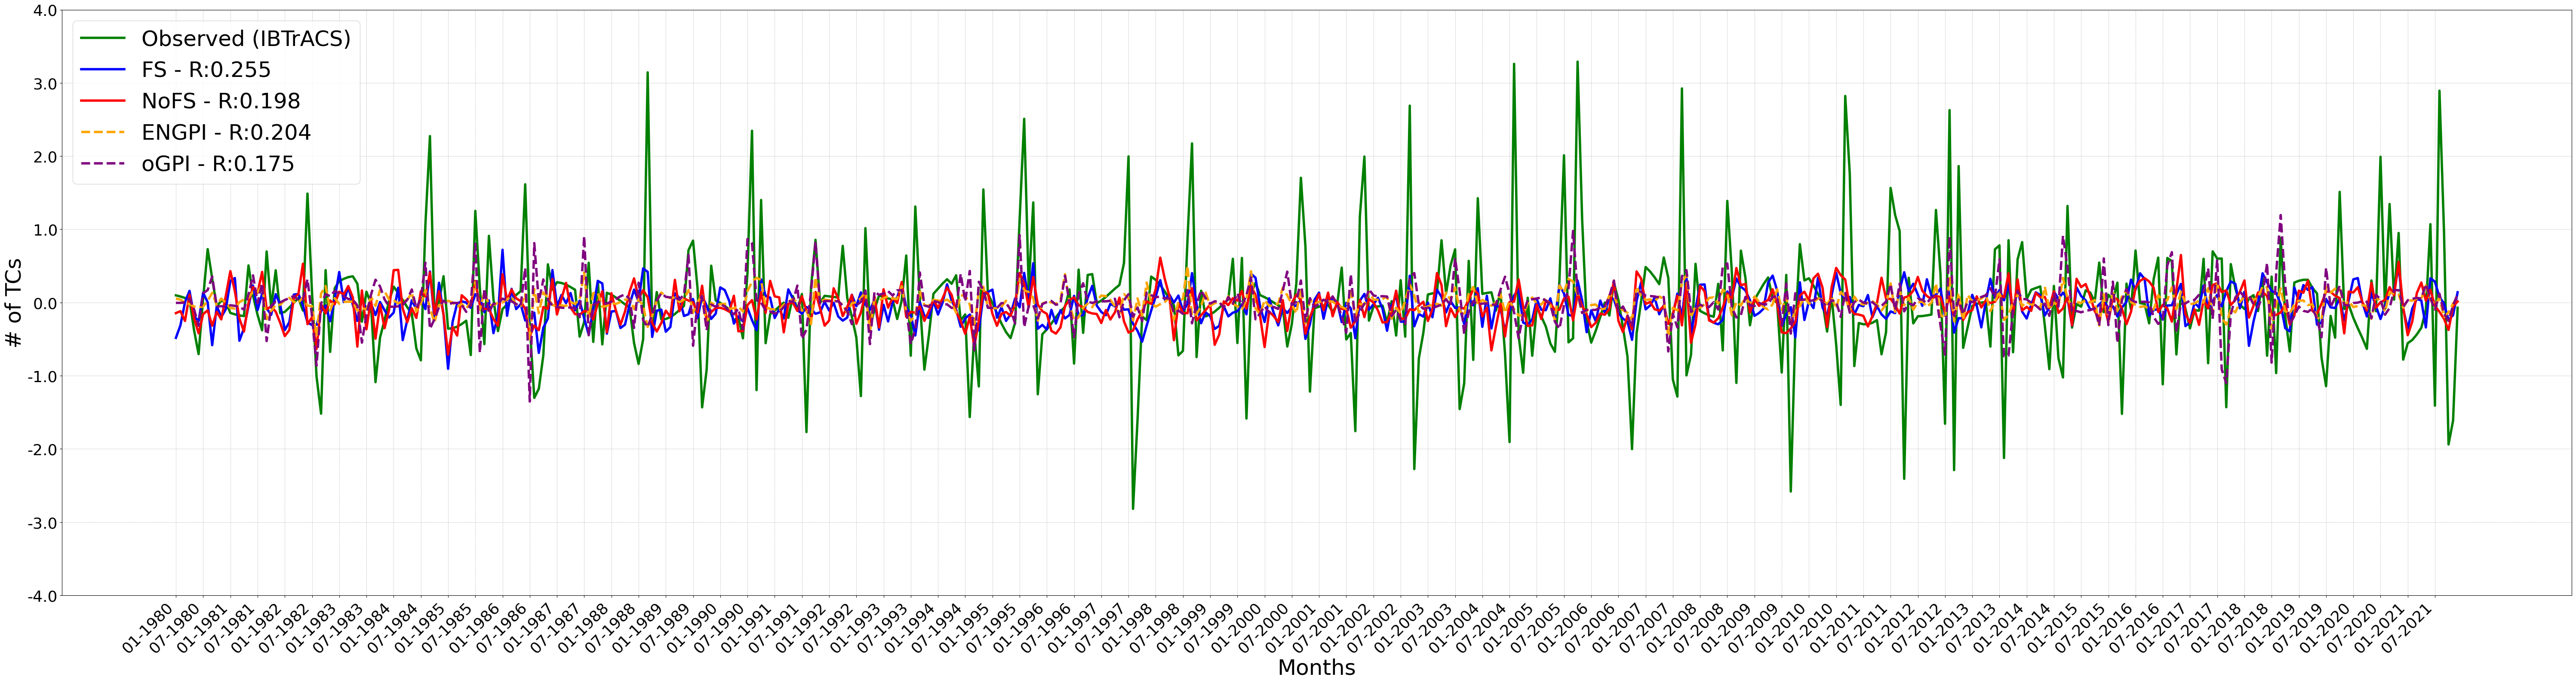

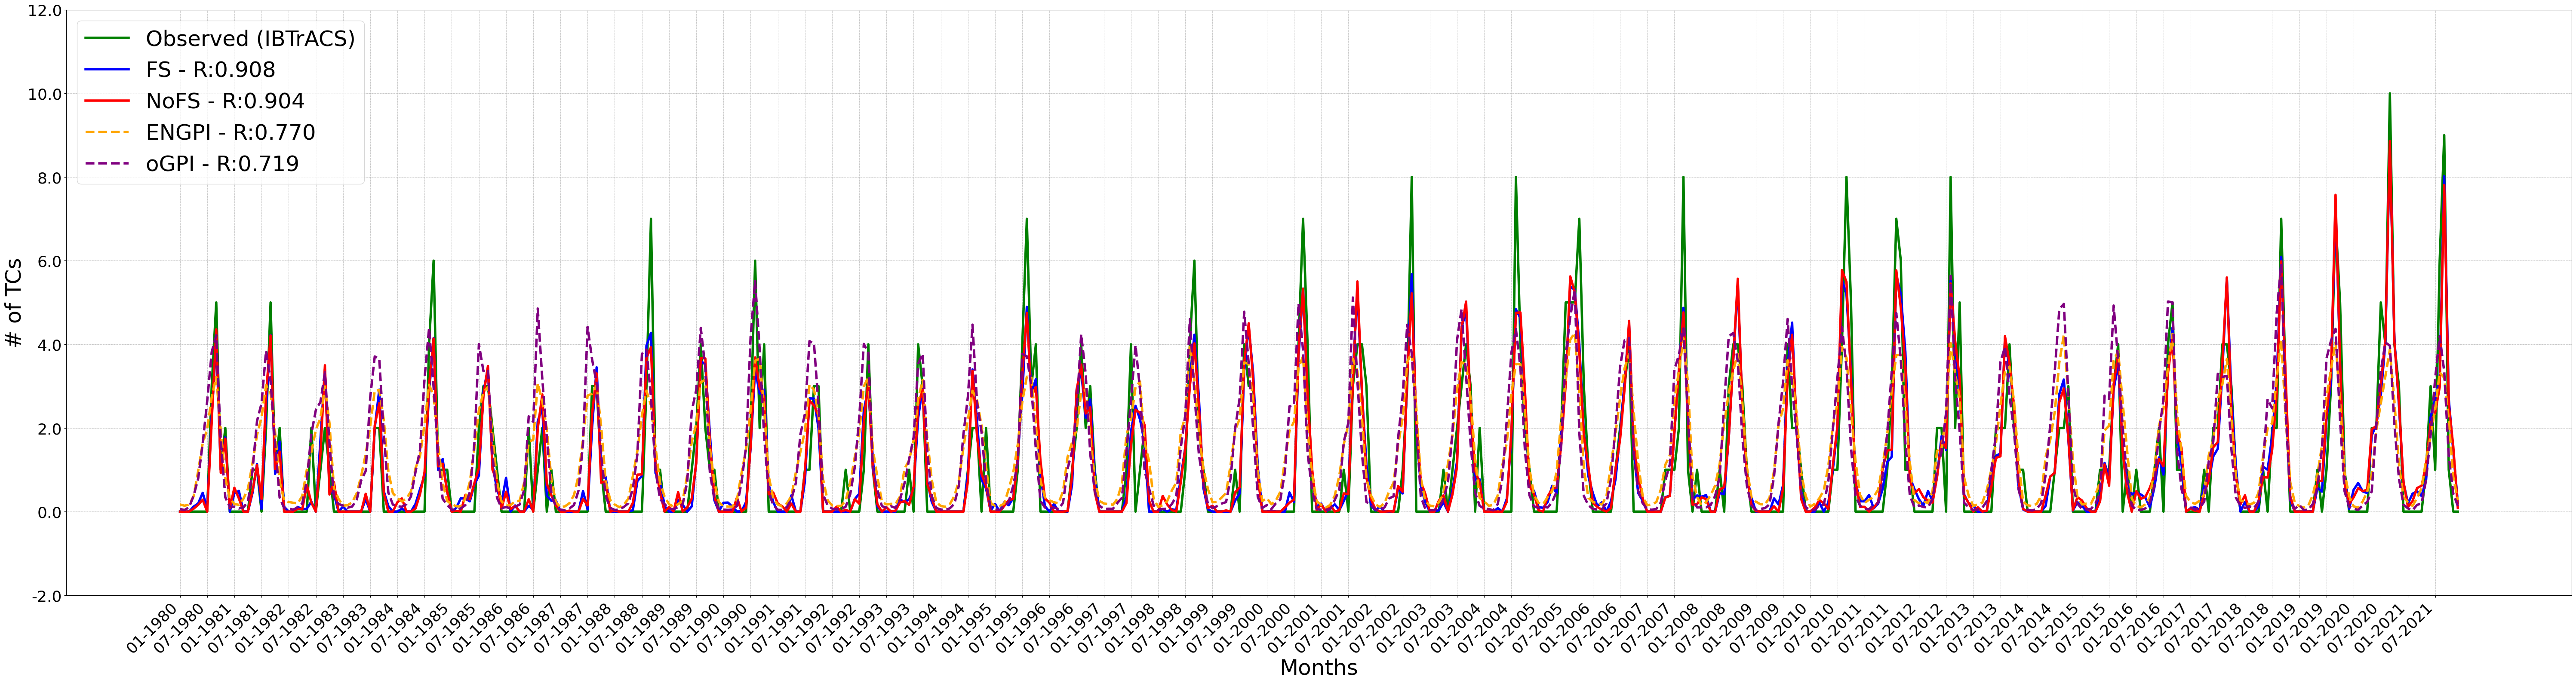

In [8]:
# Plotting the montly time series detrended and deseasonalized
fig_ts = ut.plot_monthly_time_series(target_df['resid'], Y_pred_df['resid'], Y_pred_noFS_df['resid'], engpi, ogpi, r, r_noFS, r_engpi, r_ogpi)
# Plotting the montly time series with trend and seasonality
fig_ts_TS = ut.plot_monthly_time_series(target_df_TS, Y_pred_df_TS, Y_pred_noFS_df_TS, engpi_TS, ogpi_TS, r_TS, r_noFS_TS, r_engpi_TS, r_ogpi_TS)

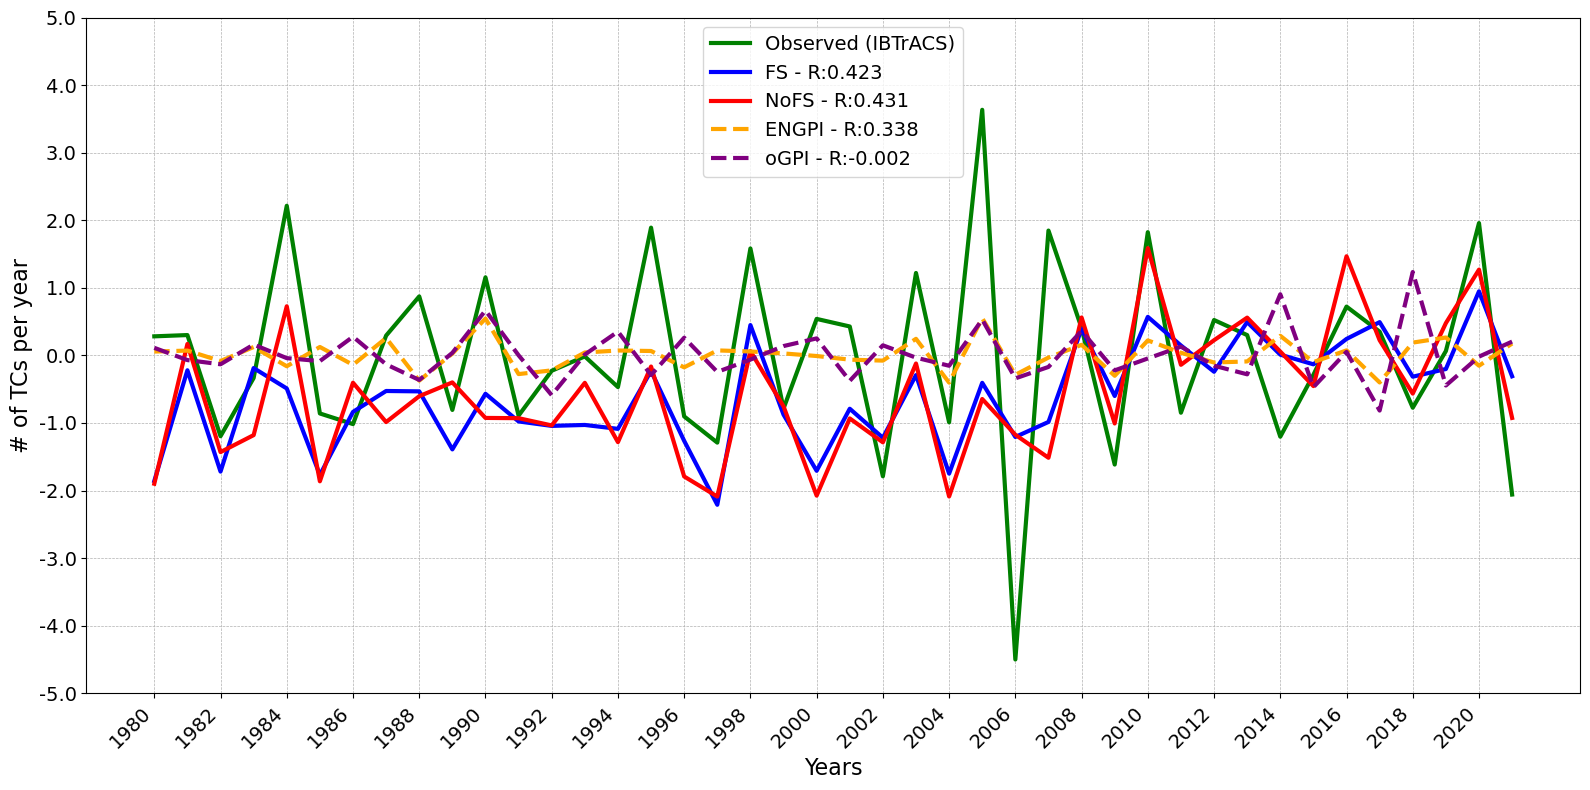

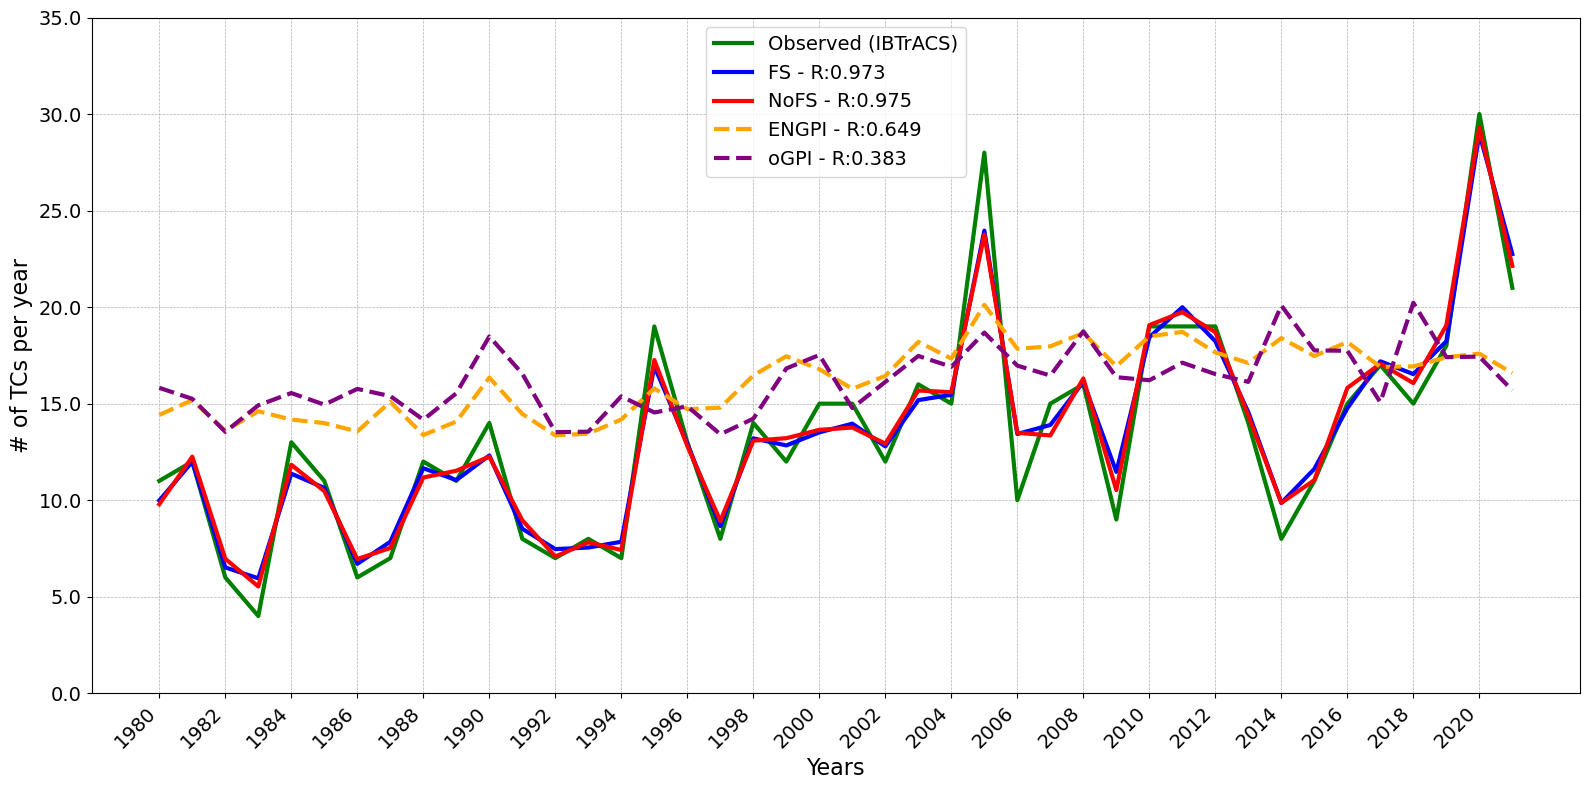

In [9]:
# Plotting the annual time series detrended and deseasonalized
fig_annual = ut.plot_annual_time_series(target_df_annual['resid'], Y_pred_df_annual['resid'], Y_pred_noFS_df_annual['resid'], engpi_annual, ogpi_annual, rY, rY_noFS, rY_engpi, rY_ogpi)
# Plotting the annual time series with trend and seasonality
fig_annual_TS = ut.plot_annual_time_series(target_df_annual_TS, Y_pred_df_annual_TS, Y_pred_noFS_df_annual_TS, engpi_annual_TS, ogpi_annual_TS, rY_TS, rY_noFS_TS, rY_engpi_TS, rY_ogpi_TS)

**Selected Features**

In [10]:
# Determine selected features according to the run_name
if 'selfeat' in run_name:
    perc = run_name.split('_top20')[0].split('selfeat')[1]
    csv_path = os.path.join(fs_dir, 'results', f'selected_features_best_models_{basin}_{n_clusters}_noTS.csv')
    df_perc_sel = pd.read_csv(csv_path, index_col=0)
    selected_features = df_perc_sel['80'].dropna().to_list()
elif 'test' in run_name:
    experiment_filename = f'1980-2022_{n_clusters}clusters_8vars_9idxs.csv'
    sol_filename = 'linreg_' + experiment_filename
    output_dir = os.path.join(fs_dir, 'results', basin, run_name)
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    best_solution = best_solution.to_numpy().flatten()
    column_names = predictors_df.columns.tolist()
    final_sequence = best_solution[len(column_names):2*len(column_names)]
    sequence_length = best_solution[:len(column_names)]
    feat_sel = best_solution[2*len(column_names):]
    variable_selection = feat_sel.astype(int)
    time_sequences = sequence_length.astype(int)
    time_lags = final_sequence.astype(int)
    selected_features = []
    for c, col in enumerate(predictors_df.columns):
        if variable_selection[c] == 0 or time_sequences[c] == 0:
            continue
        for j in range(time_sequences[c]):
            selected_features.append(str(col))
else:
    raise ValueError(f'Unknown run name: {run_name}')
# Get the variables names and the selected clusters
variables_with_cluster = [var for var in selected_features if 'cluster' in var]
variables_without_cluster = [var for var in selected_features if 'cluster' not in var]
variable_names_cluster = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names_cluster = list(set(variable_names_cluster))
variable_names_cluster.sort()

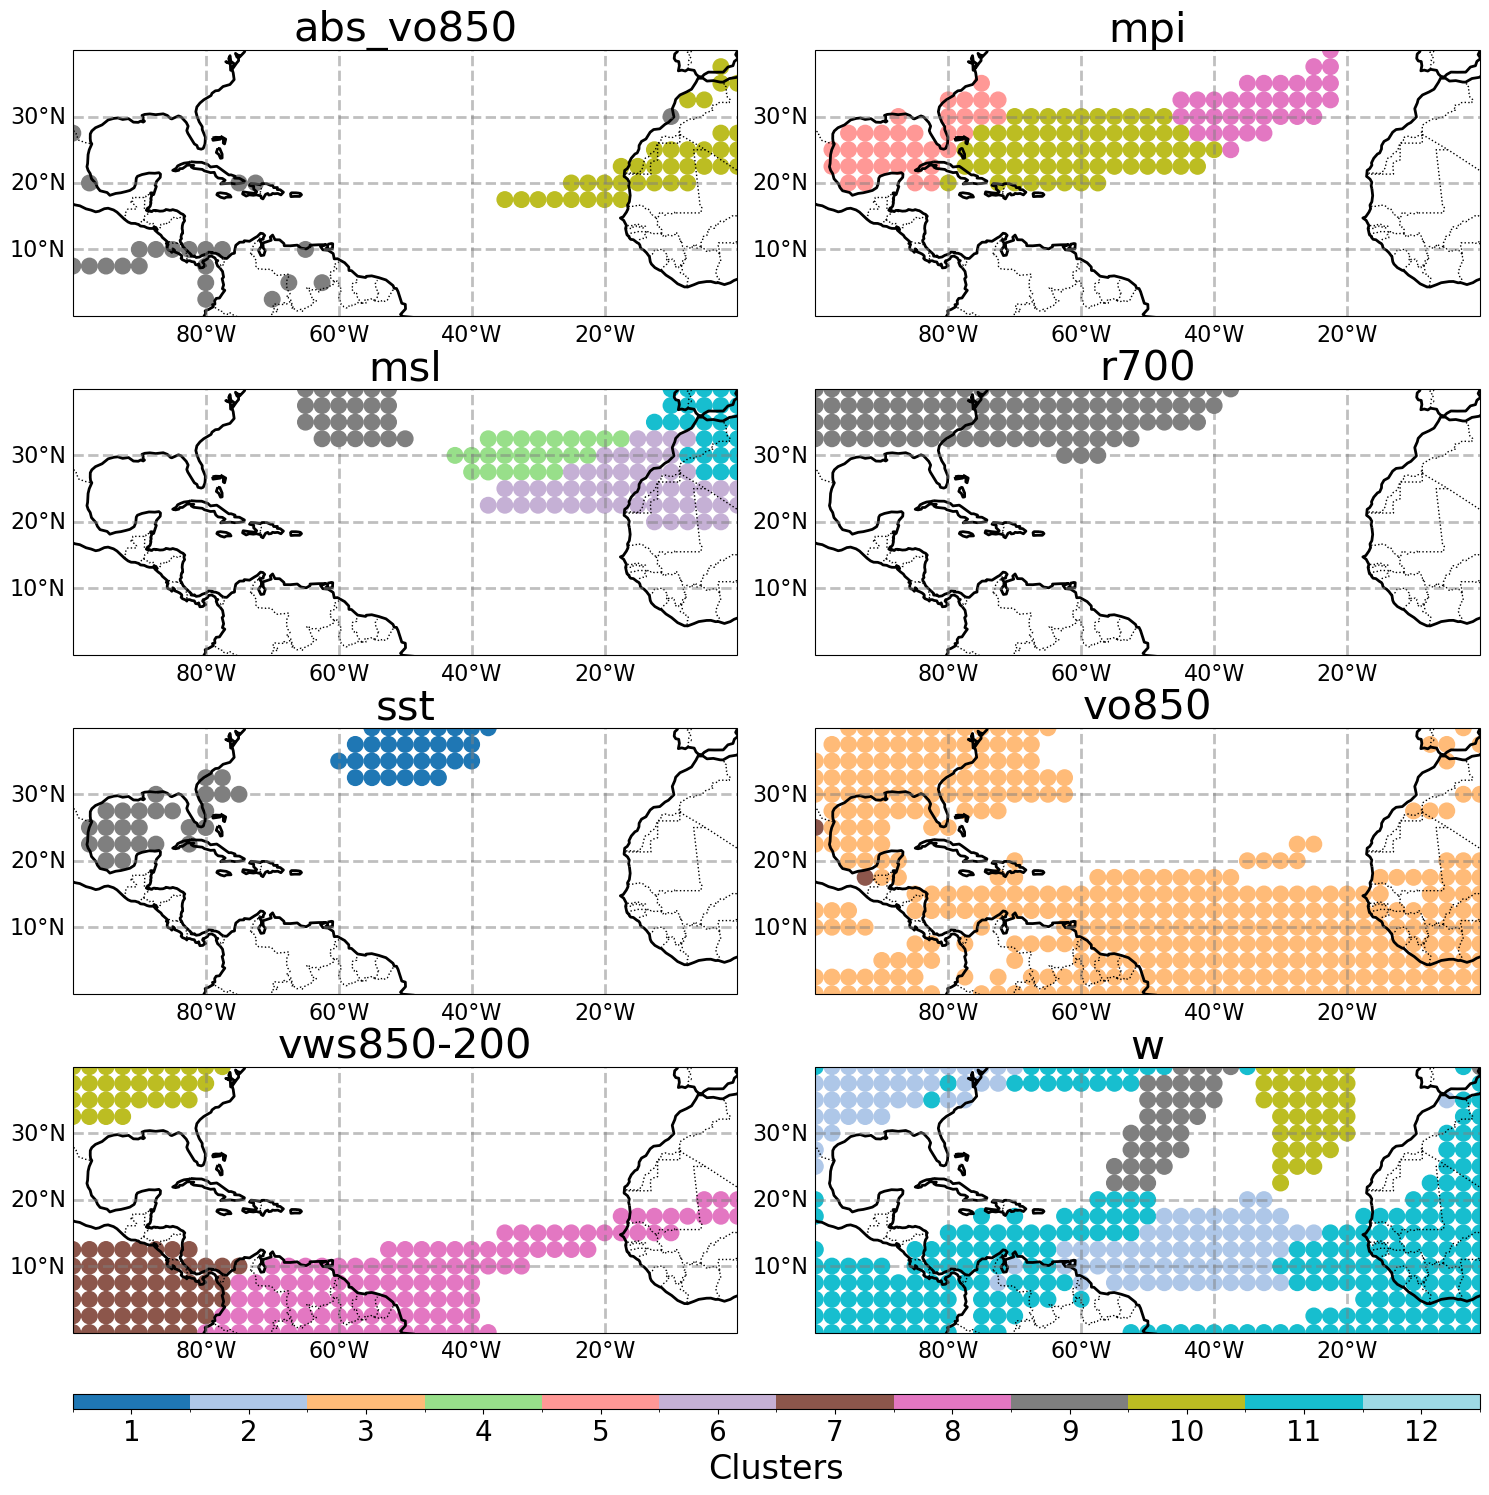

In [11]:
fig_clusters = ut.plot_variables_clusters(basin, n_clusters, cluster_data_dir, variable_names_cluster, selected_features)

**Print lines for LaTEX table**

In [8]:
# print(f'& FS-NN & {mse:.3f} & {r:.3f} & {mseS:.3f} & {rS:.4f} & {mseY:.3f} & {rY:.3f} \\\\')
# print(f'~ & NN & {mse_noFS:.3f} & {r_noFS:.3f} & {mseS_noFS:.3f} & {rS_noFS:.4f} & {mseY_noFS:.3f} & {rY_noFS:.3f} \\\\')
# print(f'~ & ENGPI & {mse_engpi:.3f} & {r_engpi:.3f} & {mseS_engpi:.3f} & {rS_engpi:.4f} & {mseY_engpi:.3f} & {rY_engpi:.3f} \\\\')
# print(f'~ & oGPI & {mse_ogpi:.3f} & {r_ogpi:.3f} & {mseS_ogpi:.3f} & {rS_ogpi:.4f} & {mseY_ogpi:.3f} & {rY_ogpi:.3f} \\\\')

**SHAP values**

In [71]:
## Set different parameters for following plots ##
# Dictionary containing the couples of years for each fold to used for more deepen analysis
# Fold 1: [1980-1993]
# Fold 2: [1994-2007]
# Fold 3: [2008-2021]
years_couples = {
    # 'basin': ([max_fold1, min_fold1], [max_fold2, min_fold2], [max_fold3, min_fold3])
    'GLB': ([1990, 1987], [1994, 1998], [2015, 2010]),
    'NEP': ([1982, 1988], [1997, 1995], [2015, 2010]),
    'NWP': ([1984, 1993], [2001, 1998], [2012, 2020]),
    'NA': ([1987, 1986], [1995, 2002], [2010, 2015]), # rerun training fold1 and fold2 model do not look very good
    'NI': ([1991, 1984], [1998, 1999], [2018, 2008]),
    'SI': ([1984, 1992], [2000, 1997], [2018, 2015]),
    'SP': ([1983, 1991], [1997, 1999], [2016, 2011])
    }
# Dictionary containing the selected features ordered for consistent shapley values plots
ordered_features = {
    # ordered from lowest impacting to highest impacting in shap values
    'GLB': ['PDO', 'msl_cluster11', 'abs_vo850_cluster6', 'sst_cluster12', 'vws850-200_cluster2', 'vo850_cluster8', 'month', 'abs_vo850_cluster5', 
            'mpi_cluster12', 'sst_cluster9'],
    'NEP': ['WP', 'abs_vo850_cluster9', 'w_cluster3', 'vo850_cluster6', 'vo850_cluster4', 'abs_vo850_cluster6', 'vo850_cluster7', 'r700_cluster5',
            'w_cluster9', 'vo850_cluster1'],
    'NWP': ['TSA', 'PDO', 'r700_cluster4', 'mpi_cluster2', 'msl_cluster4'],
    'NA': ['vo850_cluster6', 'vws850-200_cluster6', 'mpi_cluster3', 'vws850-200_cluster5', 'vo850_cluster2', 'mpi_cluster1', 'mpi_cluster2'],
    'NI': ['TNA', 'month', 'abs_vo850_cluster7', 'vws850-200_cluster12', 'sst_cluster9'],
    'SI': ['PNA', 'vo850_cluster9', 'WP', 'mpi_cluster9', 'TSA', 'TNA', 'vws850-200_cluster9', 'abs_vo850_cluster2', 'vo850_cluster6',
            'vws850-200_cluster8'],
    'SP': ['w_cluster4', 'mpi_cluster1', 'mpi_cluster5', 'msl_cluster7', 'msl_cluster3', 'vws850-200_cluster1', 'r700_cluster2', 'abs_vo850_cluster4', 
           'msl_cluster1', 'PDO', 'mpi_cluster3', 'month', 'r700_cluster6', 'vo850_cluster6', 'sst_cluster3', 'sst_cluster5']
}
# Dictionary containing the figures size for the shapley plots
figures_size = {
    # 'basin: [fig_shap, fig_shap_maxmin]
    'GLB': [(20, 12), (12, 24)],
    'NEP': [(20, 12), (12, 24)],
    'NWP': [(20, 8), (12, 14)],
    'NA': [(20, 10), (12, 18)],
    'NI': [(20, 8), (12, 14)],
    'SI': [(20, 12), (12, 24)],
    'SP': [(24, 22), (16, 48)]
}
# Dictionary containing the fontsize for title, axis, axis labels and colorbars of the plots
fontsizes = {
    # 'basin: [(xtickslabel, barlabel-bartickslabel-ylabel-ytickslabel, title), (xtickslabel, barlabel-bartickslabel-ylabel-ytickslabel, legendlabel)]
    'GLB': [(14, 16, 18), (14, 16, 14)],
    'NEP': [(14, 16, 18), (14, 16, 14)],
    'NWP': [(14, 16, 18), (14, 16, 14)],
    'NA': [(14, 16, 18), (14, 16, 14)],
    'NI': [(14, 16, 18), (14, 16, 14)],
    'SI': [(14, 16, 18), (14, 16, 14)],
    'SP': [(18, 20, 22), (20, 22, 20)],
}
# Dictionary containing the range of shap values to determine ticks of the x-axis
x_axis_arrays = {
    'GLB': np.arange(-3, 3.1, 1),
    'NEP': np.array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    'NWP': np.arange(-3, 3.1, 1),
    'NA': np.array([-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'NI': np.array([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]),
    'SI': np.array([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    'SP': np.array([ -0.6, -0.4, -0.2, 0.0, 0.2, 0.4 , 0.6, 0.8, 1.0]),
    }
# Dicionary containing the marker sizes for the shap plots
marker_sizes = {
    # 'basin': [plot_size, (plot_size, legend_size)]
    'GLB': [16, (64, 10)],
    'NEP': [16, (64, 10)],
    'NWP': [16, (64, 10)],
    'NA': [16, (64, 10)],
    'NI': [16, (64, 10)],
    'SI': [16, (64, 10)],
    'SP': [24, (128, 14)],
    }
# Create a DataFrame with fold number corresponding to each year
kfold = KFold(n_splits=n_folds)
test_years_df = pd.DataFrame(0, index=years, columns=['fold'])
for nf, (train_index, test_index) in enumerate(kfold.split(years)):
    test_years_df.loc[years[test_index], 'fold'] = nf

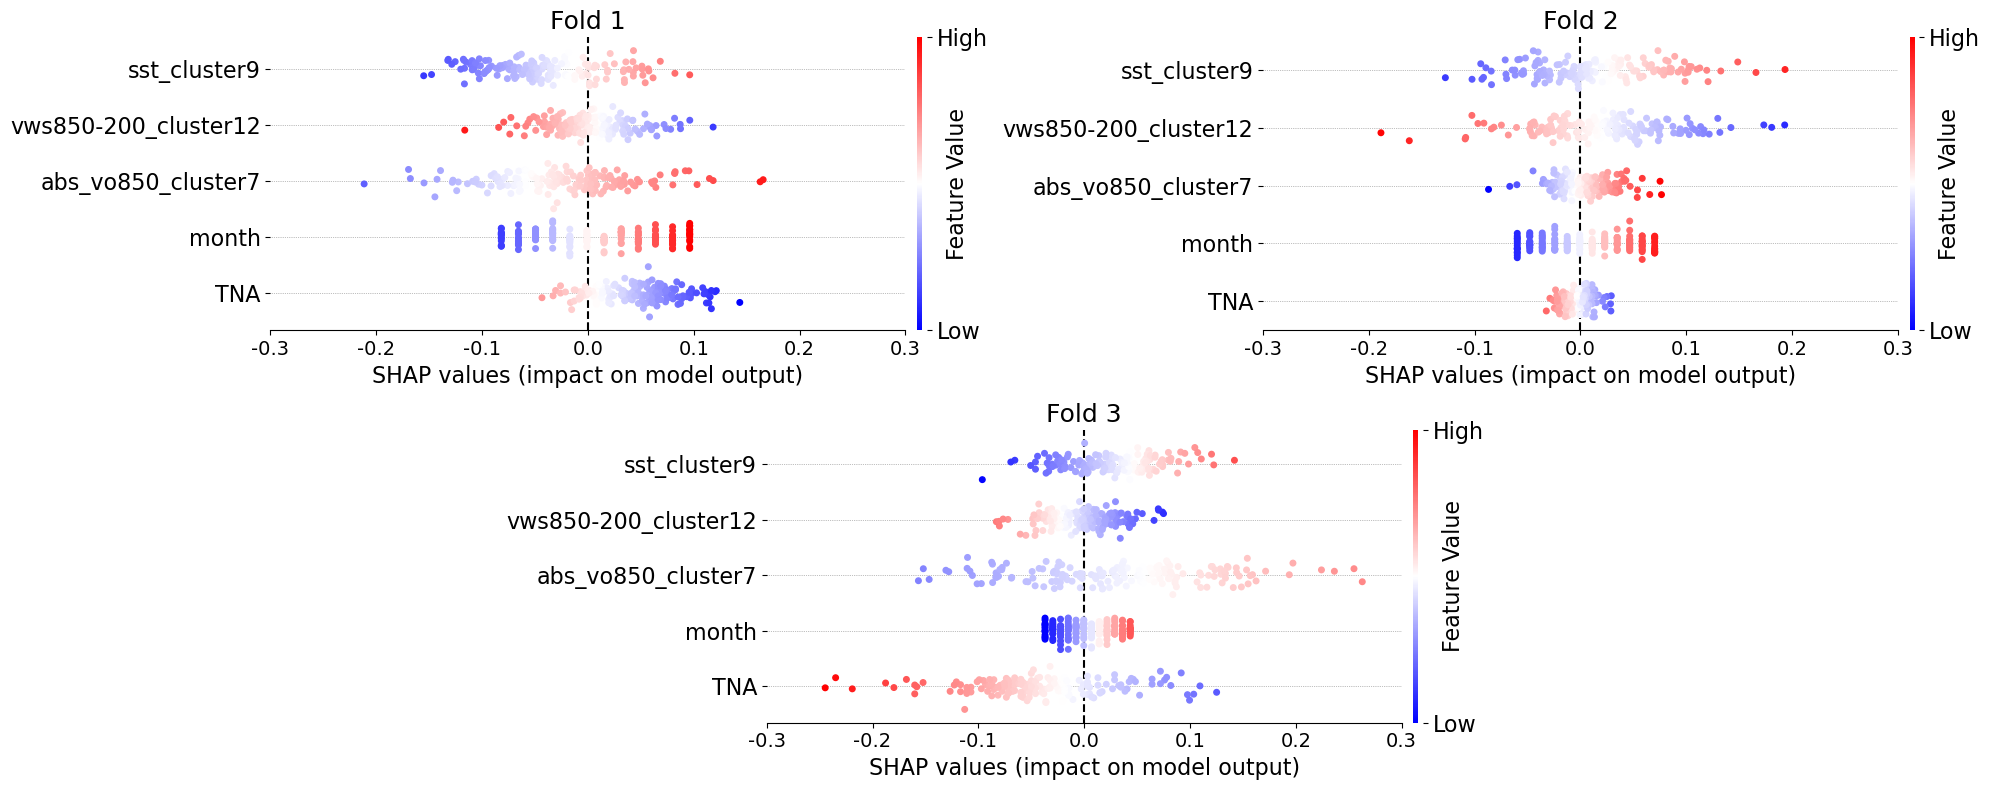

In [72]:
basin_ordered_features = ordered_features[basin]
x_axis = x_axis_arrays[basin]
fig_size = figures_size[basin][0]
fonts_size = fontsizes[basin][0]
marker_size = marker_sizes[basin][0]
# Set the figure and the gridspec for the subplots -> horizontal layout
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(2, 4, figure=fig)
ax_pos = [0, 2, 5]
jitter_strength = 0.12

# Cycle over the shap values of the 3 folds
for nf, shape_values in enumerate(shap_values_mlp):
    feat_names = np.array(shape_values.feature_names)
    # Set the colorbar for the subplots
    data_values = shape_values.data
    vmin = data_values.min()
    vmax = data_values.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap('bwr')
    # Create the subplot
    ax = fig.add_subplot(gs[ax_pos[nf]:ax_pos[nf]+2])
    # Plot the SHAP values
    for n_feat, feature in enumerate(basin_ordered_features):
        # Get the position of the feature in the SHAP values
        feat_pos = np.where(feature == feat_names)[0][0]
        # Get the data for the scatter plot
        x_data = shape_values.values[:, feat_pos]
        spread = np.random.normal(0, jitter_strength, size=x_data.shape)
        y_data = np.zeros_like(x_data) + n_feat + spread
        color_data = data_values[:, feat_pos]
        # Plot the scatter plot
        ax.scatter(x_data, y_data, c=color_data, cmap=cmap, norm=norm, s=marker_size)
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.01)
    cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
    cbar.set_ticks([vmin, vmax]) # set the ticks
    cbar.set_ticklabels(['Low', 'High'], fontsize=fonts_size[1]) # set the tick labels
    cbar.outline.set_visible(False) # remove the colorbar outline
    cbar.set_label('Feature Value', labelpad=-30, fontsize=fonts_size[1])
    # Set yticks
    ax.set_yticks(np.arange(len(basin_ordered_features)))
    ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': fonts_size[1]})
    # Set xticks
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x_axis, fontdict={'fontsize': fonts_size[0]})
    ax.set_xlabel('SHAP values (impact on model output)', fontdict={'fontsize': fonts_size[1]})
    # Add a vertical line at 0
    ax.axvline(x=0, color='black', linestyle='--', zorder=0)
    # Add horizontal lines at each feature
    for n_feat in range(len(basin_ordered_features)):
        ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
    # Set the title
    ax.set_title(f'Fold {nf+1}', fontsize=fonts_size[2])
    # Remove axis outline
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save the figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

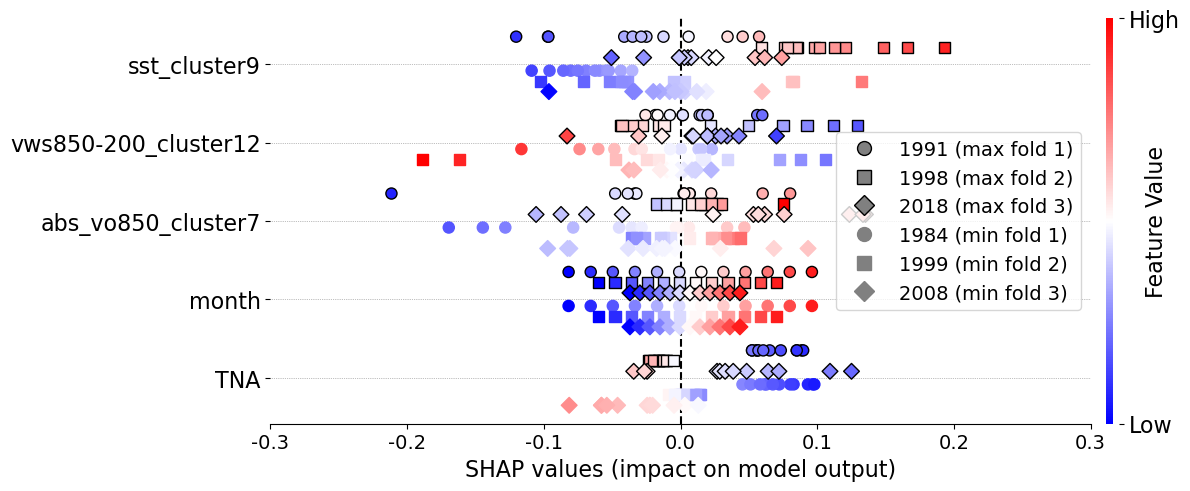

In [73]:
basin_years_couple = years_couples[basin]
fig_size = figures_size[basin][1]
fonts_size = fontsizes[basin][1]
marker_size = marker_sizes[basin][1]
# Set the figure and the gridspec for the subplots -> vertical layout
fig = plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(3, 1, figure=fig)
ax = fig.add_subplot(gs[0])
vmins = []
vmaxs = []
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Set the colorbar for this subplot
    shap_years = []
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        shap_years.append(shap_year)
    data_values = np.array([shap_year.data for shap_year in shap_years])
    vmin = data_values.min()
    vmax = data_values.max()
    vmins.append(vmin)
    vmaxs.append(vmax)
vmin = min(vmins)
vmax = max(vmaxs)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('bwr')
# List for legend handles
legend_handles = []
# Set the different markers 
markers = ['o', 's', 'D']
for yb, years_for_analysis in enumerate(basin_years_couple):
    # Indentify the fold of the years considered
    fold = test_years_df.loc[years_for_analysis[0], 'fold']
    shap_values_fold = shap_values_mlp[fold]
    Y_test_fold = Y_test[fold]
    # Loop over the two years to plot the SHAP values
    for yy, year in enumerate(years_for_analysis):
        indices = Y_test_fold.index.year == year
        shap_year = shap_values_fold[indices]
        # Get the feature names and the data values
        feat_names = np.array(shap_year.feature_names)
        data_values = shap_year.data
        # Set a positions, markers and labels for the scatter plot
        yb_pos = 0.40*(2-yb) if yy == 0 else -0.40*yb
        yy_pos = 0.25 if yy == 0 else -0.25
        year_kind = 'max' if yy == 0 else 'min'
        # Make the scatter plot cycling over the predefined ordered features
        shape = markers[yb]
        for n_feat, feature in enumerate(basin_ordered_features):
            # Get the position of the feature in the SHAP values
            feat_pos = np.where(feature == feat_names)[0][0]
            # Get the data for the scatter plot
            x_data = shap_year.values[:, feat_pos]
            y_data = np.zeros_like(x_data) + n_feat*3 + yy_pos + yb_pos
            color_data = data_values[:, feat_pos]
            # Plot the scatter plot
            if yy == 0:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, edgecolors='k', s=marker_size[0])
            else:
                ax.scatter(x_data, y_data, c=color_data, marker=shape, cmap=cmap, norm=norm, s=marker_size[0])
        # Add a legend handle for the year
        if yy == 0:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markeredgecolor='k', markersize=marker_size[1], label=f'{year} ({year_kind} fold {fold+1})')
        else:
            legend_handle = mlines.Line2D([], [], color='grey', marker=shape, linestyle='None', 
                                          markersize=marker_size[1], label=f'{year} ({year_kind} fold {fold+1})')
        legend_handles.append(legend_handle)
# Add legend - reorganized
legend_handles = np.asarray(legend_handles)
new_legend_handles = legend_handles.copy()
new_legend_handles[3] = legend_handles[1]
new_legend_handles[1] = legend_handles[2]
new_legend_handles[4] = legend_handles[3]
new_legend_handles[2] = legend_handles[4]
ax.legend(handles=new_legend_handles.tolist(), loc='center right', fontsize=fonts_size[2])
# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.01)
cbar.ax.set_aspect(50) # adjust the aspect ratio to thin colorbar
cbar.set_ticks([vmin, vmax]) # set the ticks
cbar.set_ticklabels(['Low', 'High'], fontsize=fonts_size[1]) # set the tick labels
cbar.outline.set_visible(False) # remove the colorbar outline
cbar.set_label('Feature Value', fontsize=fonts_size[1], labelpad=-25)
# Set yticks
ax.set_yticks(np.arange(len(basin_ordered_features)*3)[::3])
ax.set_yticklabels(basin_ordered_features, fontdict={'fontsize': fonts_size[1]})
# Set xticks
ax.set_xticks(x_axis)
ax.set_xticklabels(x_axis, fontdict={'fontsize': fonts_size[0]})
ax.set_xlabel('SHAP values (impact on model output)', fontsize=fonts_size[1])
# Add a vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', zorder=0)
# Add horizontal lines at each feature
for n_feat in np.arange(len(basin_ordered_features)*3)[::3]:
    ax.axhline(y=n_feat, color='grey', linestyle=':', linewidth=0.5, zorder=0)
# Remove axis outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# Adjust the layout
fig.set_tight_layout(True)
# Save figure
file_path = os.path.join('figures', f'{basin}', f'shap_analysis_{basin}_years_maxmin.pdf')
fig.savefig(file_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [74]:
## Set different parameters for following plots ##
# # Dictionary containing most important features for each basin and corresponding units
# important_features = {
#     'GLB': ['sst_cluster9', 'abs_vo850_cluster5', 'mpi_cluster12']
# }
# metrics_units = {
#     'GLB': ['°C', 's$^{-1}$', 'ms$^{-1}$']
# }

# features_imp = important_features[basin]
# units = metrics_units[basin]

# markers = ['o', 's', 'D']
# # Create the figure and axis
# fig = plt.figure(figsize=(24, 6))
# gs = gridspec.GridSpec(1, 3, figure=fig)
# for ff, feature in enumerate(features_imp):
#     ax1 = fig.add_subplot(gs[ff])
#     for yy, y_cpl in enumerate(basin_years_couple):
#         feature_ts_year1 = predictors_df.loc[predictors_df.index.year == basin_years_couple[yy][0], feature]
#         ax1.plot(feature_ts_year1.index.month, feature_ts_year1.values, 'r', label=f'{basin_years_couple[yy][0]} (max)',
#                  marker=markers[yy], linewidth=2, markersize=8)
#     for yy, y_cpl in enumerate(basin_years_couple):
#         feature_ts_year2 = predictors_df.loc[predictors_df.index.year == basin_years_couple[yy][1], feature]
#         ax1.plot(feature_ts_year2.index.month, feature_ts_year2.values, 'b', label=f'{basin_years_couple[yy][1]} (min)', 
#                  marker=markers[yy], linewidth=2, markersize=8)
#     # ax1.set_xlabel('Month', fontdict={'fontsize': 16})
#     ax1.set_ylabel(f'{units[ff]}', fontdict={'fontsize': 16})
#     ax1.set_xticks(np.arange(2, 13, 2))
#     ax1.set_xticklabels(['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'], fontdict={'fontsize': 14})
#     ax1.set_yticks(ax1.get_yticks())
#     ax1.set_yticklabels(ax1.get_yticks(), fontdict={'fontsize': 14})
#     ax1.set_title(feature, fontsize=16)
#     # Set x-axis format properly
#     ax1.set_xlim([0.5, 12.5])
#     # Show legend
#     if ff == 1:
#         ax1.legend(loc=[-0.78, -0.2], ncol=6, fontsize=16)
#         a = ax1.get_yticks()
#         ax1.set_yticklabels(np.round(ax1.get_yticks(), 5), fontdict={'fontsize': 14})
# # fig.set_tight_layout(True)
# # Show the plot
# plt.show()